<a href="https://colab.research.google.com/github/Ritwik-1/Fine-Tune-SAM/blob/master/SAM_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

# FINE TUNE APPROACH 1 

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

model_checkpoint = "/content/drive/MyDrive/Colab Notebooks/assets/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint = model_checkpoint)


**FREEZING ALL IMAGE ENCODER PARAMS**

In [ ]:
print(type(sam))

# Freezed all the Image encoder parameters 
for param in sam.image_encoder.parameters():
    param.requires_grad = False

<class 'segment_anything.modeling.sam.Sam'>


PARAMS IN PROMPT ENCODER

In [ ]:
# IDEA : FREEZE THE POINT AND TEXT PROMPTS 
# BUT WHOLE MODULE HAS SUCH LESS PARAMS 

prompt_params = 0

for name,param in sam.prompt_encoder.named_parameters():
    # print(name)
    # print(param)
    prompt_params += param.numel()

print(prompt_params)

# Bas 6220?


6220


PARAMS IN IMAGE ENCODER

In [ ]:
image_params = 0

for name,param in sam.image_encoder.named_parameters():
    # print(name)
    # print(param)
    image_params += param.numel()

print(image_params)


637026048


PARAMS IN MASK DECODER

In [ ]:
mask_params = 0

for name,param in sam.mask_decoder.named_parameters():
    # print(name)
    # print(param)
    mask_params += param.numel()

print(mask_params)

4058340


In [ ]:
trainable_params = 0
non_trainable_params = 0

# parameters are tensors , for getting actual no. of parameters we need to 
# count the no. of elements in each tensor 
# which is done using numel() function

for i in sam.parameters():
    if(i.requires_grad == False):
        # print(name)
        non_trainable_params+=i.numel()
    else:
        trainable_params+=i.numel()

print("Trainable params : ",trainable_params)
print("Non-trainable params : ",non_trainable_params)

Trainable params :  4064560
Non-trainable params :  637026048


**TO ADD MORE MLP LAYERS TO THE MASK DECODER**

In [ ]:
# for name,param in sam.mask_decoder.named_parameters():
#     print(name)

for name,param in sam.mask_decoder.named_parameters():
  #  if(name == 'MLP'):
      print(name)


In [ ]:
for name in sam.mask_decoder.children():
  #  if(name == 'MLP'):
      print(name)


In [ ]:
for i in range(4):
  for j in range(3):
     print(sam.mask_decoder.output_hypernetworks_mlps[i].layers[j].weight.shape)
     print(sam.mask_decoder.output_hypernetworks_mlps[i].layers[j].bias.shape)
     print("lol")

In [ ]:
# Adding another MLP to the IoU prediction 

# DO NOT RUN AGAIN

import torch.nn as nn

additional_layer2 = nn.Linear(in_features=256, out_features=256,bias = True)

sam.mask_decoder.iou_prediction_head.layers.insert(1,additional_layer2)

In [ ]:
for name in sam.mask_decoder.children():
      print(name)

In [ ]:
# Checking dimensions again :
for i in range(4):
     print(sam.mask_decoder.iou_prediction_head.layers[i].weight.shape)
     print(sam.mask_decoder.iou_prediction_head.layers[i].bias.shape)
     print("lol")

In [ ]:
# ADDING MLPs to THE OUTPUT_HYPERNETWORKS MLP MODULE

# DO NOT RUN AGAIN 

module = sam.mask_decoder.output_hypernetworks_mlps

for i in range(4):
    lin_layer = nn.Linear(in_features=256, out_features=256,bias = True)
    module[i].layers.insert(1,lin_layer)

print(module)

In [ ]:
for name in sam.mask_decoder.children():
      print(name)

In [ ]:
for i in range(4):
  for j in range(4):
     if(j == 2):
      print("This is added layer")
     print(sam.mask_decoder.output_hypernetworks_mlps[i].layers[j].weight.shape)
     print(sam.mask_decoder.output_hypernetworks_mlps[i].layers[j].bias.shape)

In [ ]:
# SAVING THE MODEL IN THIS CONFIGURATION

# i.e 1) Image encoder is freezed 
    # 2) added 1 more MLP layer to the final output predictions

  # for now

  # Now moving to training

import torch

torch.save(sam,'/content/drive/MyDrive/SAM_FT1/sam.pt')

# torch.save(sam.state_dict(), '/content/drive/MyDrive/SAM_FT1/sam.pth')

# START RUNNING HERE


In [ ]:
# Loading the model
import torch
sam_loaded = torch.load('/content/drive/MyDrive/SAM_FT1/sam.pt')


In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

model_checkpoint = "/content/drive/MyDrive/Colab Notebooks/assets/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam_original = sam_model_registry[model_type](checkpoint = model_checkpoint)

In [ ]:
import torch 
from segment_anything import SamPredictor

# device = "cuda"

# sam_loaded.to(device=device)

# sam_original.to(device = device)

predictor_loaded = SamPredictor(sam_loaded)

predictor_original = SamPredictor(sam_original)
# Now take only 1 patient and make 1 train and one label

# PYDICOM INSTALL

In [1]:
from google.colab.patches import cv2_imshow

In [2]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.8 MB/s eta 0:00:00


# RUNNING ON ONLY 1 EXAMPLE

**Trying to run on 1 image/label first**

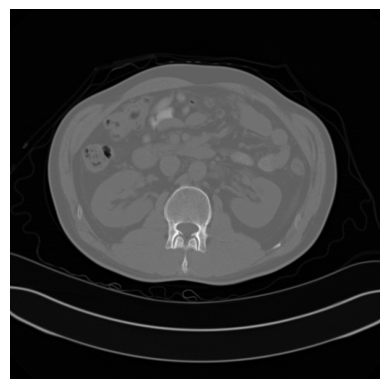

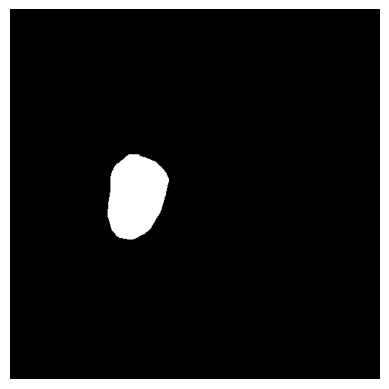

<class 'numpy.ndarray'>
(61, 512, 512)
(512, 512)


In [ ]:
import cv2
import pydicom
import matplotlib.pyplot as plt

# First patient ki 35th slice of CT
test_image = "/content/drive/MyDrive/manifest-1680809675630/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_001/08-22-2000-NA-CT ABDOMEN-56266/2.000000-Pre Abd 5.0 B40f-18492/1-35.dcm"

# Taking the 35th segmentation from this
label_seg = "/content/drive/MyDrive/manifest-1680809675630/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_001/08-22-2000-NA-CT ABDOMEN-56266/300.000000-Segmentation-33545/1-1.dcm"


dicom_image = pydicom.dcmread(test_image)
pixel_data = dicom_image.pixel_array


plt.imshow(pixel_data, cmap='gray')
plt.axis('off')  
plt.show()

dicom_image_labels = pydicom.dcmread(label_seg)
pixel_data_labels = dicom_image_labels.pixel_array

plt.imshow(pixel_data_labels[35], cmap='gray')
plt.axis('off') 
plt.show()

print(type(pixel_data_labels))
print(pixel_data_labels.shape)
print(pixel_data_labels[35].shape)



**SEEING SHAPES OF BOTH THE IMAGES**

In [ ]:
test_CT_image = pixel_data
label_CT_seg = pixel_data_labels[35]

print(test_CT_image.shape)
print(label_CT_seg.shape)

(512, 512)
(512, 512)


**GETTING THE BOUNDING BOX OF THE SEG
IN THE 512x512 plane**

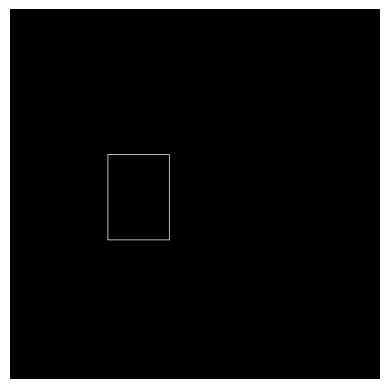

[(135, 201, 220, 319)]


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

threshold = 0  # Choose an appropriate threshold value
binary_mask = (label_CT_seg > threshold).astype(np.uint8)

# Find contours of the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank 512x512 plane
plane = np.zeros((512, 512), dtype=np.uint8)

# Iterate over the contours and compute the bounding box coordinates
bounding_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, x + w, y + h))
    
    # Plot the bounding box on the plane
    cv2.rectangle(plane, (x, y), (x + w, y + h), (255, 255, 255), 1)

# Plot the plane with bounding boxes
plt.imshow(plane, cmap='gray')
plt.axis('off')
plt.show()


print(bounding_boxes)

In [ ]:
# Now have the box , image , can produce the mask and also have the label can calc loss

import cv2
import numpy as np

image_jpg = cv2.cvtColor(test_CT_image, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR (OpenCV default format)
cv2.imwrite('image.jpg', image_jpg)  # Save the JPEG image

# Read JPEG image and convert it back to NumPy array
image_loaded = cv2.imread('image.jpg')  # Read the JPEG image
image_np_loaded = cv2.cvtColor(image_loaded, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

test_CT_image = image_np_loaded

In [ ]:
predictor_original.set_image(test_CT_image)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    return mask_image 

In [ ]:
input_box = np.array(bounding_boxes[0])

masks, _, _ = predictor_original.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

print(type(masks))

print(masks[0])

print(masks[0].shape)

mask_image = show_mask(masks[0], plt.gca())

print("---------------------------------------")
print(mask_image)
print(mask_image.shape)
ax = plt.gca()
ax.imshow(masks[0])



In [ ]:
# now loss is between masks[0] and pixel_data_labels[35]

# CONVERSION TO FLOAT32 AND CONVERTING TRUE TO 0 and 1s 

mask_int = masks[0].astype(int)
mask_float = masks[0].astype("float32")

pixel_data_labels_float = pixel_data_labels[35].astype("float32")

print(mask_float)
print(pixel_data_labels_float)

print(mask_float.shape)
print(pixel_data_labels_float.shape)

In [ ]:
# loss calculation between mask and this output dekhna padega 
import torch.nn.functional as F
import torch

t1 = torch.from_numpy(mask_float)                    # output
t2 = torch.from_numpy(pixel_data_labels_float)         # label

print(t1.shape)
print(t2.shape)


intersection = (t1 * t2).sum().item()
union = t1.sum().item() + t2.sum().item()

dice_coefficient = (2.0 * intersection) / (union + 1e-8)  # Adding a small constant to avoid division by zero

print(dice_coefficient)


torch.Size([512, 512])
torch.Size([512, 512])
0.8474323704717747


# START OF FULL DATASET CREATION

POINTS FOR FULL DATASET 

-> Train_set_X 
   images = a vector 
   first 120 = patient 1 
   next 120 = patient 2
   and so on
   image ko dicom se jpg
   mai karna hai and then to 
   numpy array 

-> bounding_boxes = a vector
   bb[i] is bb for images[i]
   how to calculate , make a
   function image jayegi and
   BB return karegi and then 
   append bb[0] to array

-> labels = a vector
   labels[i] correspond to label
   for images[i]
   512x512 ka seg mask directly daaldo
   after convert to float32

-> NOW TRAINING,
   output of SAM is a mask 
   Take mask[0] then it is 512x512
   convert to float32
   and then compare that with label
   loss = loss_fn(output,label) 
    
   ese training loop done 

  -> OUTPUT OF SAM IS A MASK WITH TRUE AND FALSE
     WE HAVE TO CONVERT IT TO 0 and 1 and also 
     to float32 for the dice_loss to work


In [4]:
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
# label_CT_seg is the 512x512 seg map tensor for the tumour

def getBoundingBox(label_CT_seg):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    threshold = 0  # Choose an appropriate threshold value
    binary_mask = (label_CT_seg > threshold).astype(np.uint8)

    # Find contours of the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank 512x512 plane
    plane = np.zeros((512, 512), dtype=np.uint8)

    # Iterate over the contours and compute the bounding box coordinates
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x + w, y + h))
        
        # Plot the bounding box on the plane
        cv2.rectangle(plane, (x, y), (x + w, y + h), (255, 255, 255), 1)

    return bounding_boxes 
    # # Plot the plane with bounding boxes
    # plt.imshow(plane, cmap='gray')
    # plt.axis('off')
    # plt.show()

In [ ]:
# Load the DICOM file
dcm = pydicom.dcmread("/content/drive/MyDrive/Colab Notebooks/assets/Patient-1-seg.dcm")

# Extract the pixel data
pixel_array = dcm.pixel_array

print(pixel_array.shape)

p = pixel_array[28]  # Extract the first channel

print(p.shape)

normalized_array = ((p - np.min(p)) / np.ptp(p) * 255).astype(np.uint8)
bgr_image = cv2.cvtColor(normalized_array, cv2.COLOR_GRAY2BGR)

cv2_imshow(bgr_image)
# Normalize the pixel values
# normalized_array = ((pixel_array - np.min(pixel_array)) / np.ptp(pixel_array) * 255).astype(np.uint8)

# # Convert to BGR format (assuming the segmentation map is grayscale)
# bgr_image = cv2.cvtColor(normalized_array, cv2.COLOR_GRAY2BGR)

In [ ]:
import pydicom

# Load the DICOM image
# dcm = pydicom.dcmread("/content/drive/MyDrive/Colab Notebooks/assets/1-25.dcm")

dcm_2 = pydicom.dcmread("/content/drive/MyDrive/manifest-1680809675630/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_039/02-08-2010-NA-CT Abdomen-18373/300.000000-Segmentation-78069/1-1.dcm")
# Get the pixel data
# pixels = dcm.pixel_array
p = dcm_2.pixel_array

print(p.shape)
# print(pixels.shape)

# # Display the image using matplotlib
# plt.imshow(pixels, cmap=plt.cm.gray)
# plt.imshow(p[36], cmap='jet', alpha=0.05) # interpolation='none'
# plt.show()



(56, 512, 512)


**COLORECTAL CANCER DATASET LOADING**

HERE PROBLEM IS PATIENT 1 HAS MORE SEG MAPS THAN CT SLICES 

In [ ]:
# SEGMENTATION FILE FOR PATIENT 1 WHO HAS 161 slices of CT but 439 segmentations ????????????

dcm = pydicom.dcmread("/content/drive/MyDrive/manifest-1669817128730(Colorectal)/Colorectal-Liver-Metastases/CRLM-CT-1001/06-06-1992-NA-CT ANGIO ABD WITH PEL-75163/100.000000-Segmentation-46600/1-1.dcm")
pixels = dcm.pixel_array
print(pixels.shape)

# dcm_images = pydicom.dcmread()
# pixels_images = dcm_images.pixel_array

n_images_patient1 = len(os.listdir('/content/drive/MyDrive/manifest-1669817128730(Colorectal)/Colorectal-Liver-Metastases/CRLM-CT-1001/06-06-1992-NA-CT ANGIO ABD WITH PEL-75163/101.000000-NA-71548'))
print("No. of images for patient 1  : ",n_images_patient1)
print("No. of segmentations for patient 1 : ",pixels.shape[0])

for i in range(pixels.shape[0]):
    plt.figure()
    plt.imshow(pixels[i], cmap='gray')
    plt.title(f"Segmentation Map {i+1}")
    plt.axis('off')
    plt.show()

YE FINALLY USE HONGE TRAINING MAI

In [9]:
CT_Images = []
Bounding_Boxes = []
Seg_Labels = []

THIS IS DATASET SORTING USING OS MODULE

In [21]:
import os

# local drive directory containing all patient files
patients_dir = "/content/drive/MyDrive/manifest-1669817128730(Colorectal)/Colorectal-Liver-Metastases"

os.chdir(patients_dir)

patients = os.listdir(patients_dir)
patients = patients[::-1]
patients.pop()

total_images = 0
total_segs = 0
total_patients = 0

for patient in patients:
    total_patients += 1
   # Now we are in patient say CRLM-CT-1001
    
    # CT_mode is the only folder(which contains further files) in the patient folder
    CT_mode = os.listdir(os.path.join(patients_dir,patient))
    
    patient_path = os.path.join(patients_dir,patient)

    patient_files_folders = os.listdir(os.path.join(patient_path,CT_mode[0]))
    # Now patient_files_folders[0] must be CT images
    # and patient_files_folders[1] must be masks
    
    CT_mode_path = os.path.join(patient_path,CT_mode[0])

    patient_seg_path = os.path.join(CT_mode_path,patient_files_folders[1])
    patient_images_path = os.path.join(CT_mode_path,patient_files_folders[0])
    
    # patient_seg is a vector which contains all patient segmentations(1 patient only)
    patient_seg = os.listdir(patient_seg_path)

    #patient CT_images contains all the patient CT_images (1 patient only)
    patient_CT_images = os.listdir(patient_images_path)

    total_images += len(patient_CT_images)
    total_segs += len(patient_seg)

print("Total patients : ",total_patients)
print("Total Images : ",total_images)
print("Total_segmentation_files : ",total_segs)

 

Total patients :  197
Total Images :  11018
Total_segmentation_files :  6819


# TRAINING

ONLY STRUCTURE , THIS IS TO BE MODIFIED ALOT

In [ ]:
def dice_loss(pred, target):
    intersection = (pred * target).sum()
    dice_coef = (2.0 * intersection) / (pred.sum() + target.sum() + 1e-8)  
    return 1 - dice_coef

This is the function which would produce outputs for a batch using 
SAM modified model

In [ ]:
def calculateOutputSAM(sam,images,bounding_boxes,batch_size):
    # here all are tensors of size batch_size 
    # image[i] and bounding_boxes[i] ko sam mai bhejo 
    # and output nikalo
    # sabko vector mai daalo 
    # tensor banake and return karado 
    a = 10
    b = 20

    return a 

In [ ]:
import torch
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume 
# Train_images = [t1,t2,t3,t4]
# Bounding_box_train = [b1,b2,b3,b4]
# Train_labels = [l1,l2,l3,l4]

# Test_images , Bounding_box_Test , Test_labels 
# same for validation 

# We use the AdamW [68] optimizer (β1 =0.9, β2 = 0.999)

# The batch size is 256 images

# To regularize SAM,
# we set weight decay (wd) to 0.1 and apply drop path [53]
# (dp) with a rate of 0.4. We use a layer-wise learning rate
# decay [5] (ld) of 0.8.

#  No data augmentation is applied

optimizer = torch.optim.AdamW(
    sam_loaded.parameters(),
    lr = 8e-4,
    betas = (0.9,0.999)
)

batch_size = 256
num_epochs = 10


train_images = []
bounding_boxes = []
segmentation_masks = []

# Convert the input vectors to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).to(device)
bounding_boxes_tensor = torch.tensor(bounding_boxes, dtype=torch.float32).to(device)
segmentation_masks_tensor = torch.tensor(segmentation_masks, dtype=torch.float32).to(device)

# Combine the input tensors into a single dataset
dataset = torch.utils.data.TensorDataset(train_images_tensor, bounding_boxes_tensor, segmentation_masks_tensor)

# Create a data loader for batching
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Set the model to training mode
    sam_loaded.train()

    # Variables to track accuracy
    correct = 0
    total = 0
    
    # Iterate over the data loader
    for batch_idx, (images, bounding_boxes, masks) in enumerate(data_loader):
        
        # images , bounding_boxes,masks are tensors with 
        # first dimensions as 256 (batch size)

        images = images.to(device)
        bounding_boxes = bounding_boxes.to(device)
        masks = masks.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        outputs = calculateOutputSAM(sam_loaded,images,bounding_boxes,batch_size)
        
        # Calculate the Dice loss
        loss = dice_loss(outputs, masks)
        
        # Backward pass
        loss.backward()
        
        # Update the model parameters
        optimizer.step()

        # Calculate accuracy
        predicted_masks = (outputs > 0.5).float()
        correct += (predicted_masks == masks).sum().item()
        total += masks.numel()
        
        # Print the loss for every few iterations
        if (batch_idx+1) % 10 == 0:
           accuracy = 100 * correct / total
           print(f"Batch {batch_idx+1}/{len(data_loader)} Loss: {loss.item():.4f} Accuracy: {accuracy:.2f}%")


# TESTING

ONLY STRUCTURE , THIS IS TO BE MODIFIED ALOT

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

# Assuming test_images, test_bounding_boxes, and test_segmentation_masks are your test input vectors
# Assuming model is your trained model

# Set the device for computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the batch size
batch_size = 256

test_images = []
test_bounding_boxes = []
test_segmentation_masks = []

# Convert the test input vectors to PyTorch tensors
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).to(device)
test_bounding_boxes_tensor = torch.tensor(test_bounding_boxes, dtype=torch.float32).to(device)
test_segmentation_masks_tensor = torch.tensor(test_segmentation_masks, dtype=torch.float32).to(device)

# Combine the test input tensors into a single dataset
test_dataset = torch.utils.data.TensorDataset(test_images_tensor, test_bounding_boxes_tensor, test_segmentation_masks_tensor)

# Create a data loader for batching the test data
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Set the model to evaluation mode
sam_loaded.eval()

# Variables to track accuracy and predictions
correct = 0
total = 0
all_predictions = []
all_labels = []

# Iterate over the test data loader
with torch.no_grad():
    for images, bounding_boxes, masks in test_data_loader:
        # Transfer the batch tensors to the device
        images = images.to(device)
        bounding_boxes = bounding_boxes.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = sam_loaded(images)
        
        # Threshold the predicted masks to obtain binary predictions (0 or 1)
        predicted_masks = (outputs > 0.5).float()
        
        # Flatten the predicted masks and ground truth masks
        predicted_masks = predicted_masks.view(-1)
        masks = masks.view(-1)
        
        # Calculate accuracy
        correct += (predicted_masks == masks).sum().item()
        total += masks.numel()
        
        # Store the predictions and labels for confusion matrix
        all_predictions.extend(predicted_masks.cpu().tolist())
        all_labels.extend(masks.cpu().tolist())

# Calculate accuracy
accuracy = 100 * correct / total

# Create the confusion matrix
confusion_mat = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy:.2f}%")
print("Confusion Matrix:")
print(confusion_mat)
